In [1]:
# Load canonical feature order and scaler params (if present)
import os, json

FEATURE_NAMES = globals().get("FEATURE_NAMES", None)
SCALER_PARAMS = globals().get("SCALER_PARAMS", {})
fo_cands = [
    "feature_order.json",
    "artifacts_aligned/feature_order.json",
    "./feature_order.json",
    "../feature_order.json",
    "advanced/submissions/team-members/rajan-hans/feature_order.json",
]
for p in fo_cands:
    if os.path.exists(p):
        try:
            with open(p, "r") as f:
                fo = json.load(f)
            if isinstance(fo, list) and len(fo) > 0:
                FEATURE_NAMES = fo
                print(f"Loaded FEATURE_NAMES from {p} (len={len(FEATURE_NAMES)})")
                break
        except Exception:
            pass

sp_cands = [
    "scaler_params.json",
    "artifacts_aligned/scaler_params.json",
    "./scaler_params.json",
    "../scaler_params.json",
    "advanced/submissions/team-members/rajan-hans/scaler_params.json",
]
for p in sp_cands:
    if os.path.exists(p):
        try:
            with open(p, "r") as f:
                sc = json.load(f)
            if isinstance(sc, dict):
                SCALER_PARAMS = sc
                print(f"Loaded SCALER_PARAMS from {p} (len={len(SCALER_PARAMS)})")
                break
        except Exception:
            pass

globals()["FEATURE_NAMES"] = FEATURE_NAMES
globals()["SCALER_PARAMS"] = SCALER_PARAMS
print("Canonical feature/scale loader complete.")


Loaded FEATURE_NAMES from feature_order.json (len=21)
Loaded SCALER_PARAMS from scaler_params.json (len=0)
Canonical feature/scale loader complete.


**Week 3**

**Load the previously saved PyTorch DataLoader Objects from Week2**

In [2]:
import torch

X_train_tensor = torch.load("X_train_tensor.pt")
y_train_tensor = torch.load("y_train_tensor.pt")
X_val_tensor = torch.load("X_val_tensor.pt")
y_val_tensor = torch.load("y_val_tensor.pt")
X_test_tensor = torch.load("X_test_tensor.pt")
y_test_tensor = torch.load("y_test_tensor.pt")

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("✅  Data loaded and DataLoaders created.")


✅  Data loaded and DataLoaders created.


**Baseline Feedforward Neural Network for Diabetes Prediction**

In [3]:
# Baseline Feedforward Neural Network for Diabetes Prediction
import torch.nn as nn
import torch
import os

os.makedirs("mlflow_logs", exist_ok=True)

# Select device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define the feedforward neural network architecture for binary classification
class DiabetesFFNN(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesFFNN, self).__init__()
        # Sequential model: input -> hidden layers -> output
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # First hidden layer
            nn.ReLU(),  # Activation function
            nn.BatchNorm1d(128),  # Batch normalization for stability
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128, 64),  # Second hidden layer
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 1),  # Output layer (single logit for binary classification)
        )

    def forward(self, x):
        # Forward pass: returns raw logits (required for BCEWithLogitsLoss)
        return self.net(x)


# Instantiate the model and move it to the selected device
input_dim = X_train_tensor.shape[1]  # Number of input features
model = DiabetesFFNN(input_dim).to(device)
print(model)
print("✅  Model instantiated and moved to device.")


Using device: cpu
DiabetesFFNN(
  (net): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
✅  Model instantiated and moved to device.


**Define loss function and optimizer**

In [4]:
# Define loss function and optimizer for binary classification
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss (expects logits)
optimizer = optim.Adam(
    model.parameters(), lr=0.001, weight_decay=1e-5
)  # Adam optimizer

print("✅  Loss function and optimizer defined.")


✅  Loss function and optimizer defined.


 **Training the model - Skip this and use the Training with ML Flow**

In [5]:
# Training loop with validation monitoring, MLflow integration, and best model saving, including precision, recall, F1, and AUC
import time
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import mlflow
import mlflow.pytorch
import os

mlflow.set_tracking_uri(
    f"file:///{os.path.abspath('mlflow_logs').replace(os.sep, '/')}"
)  # Store MLflow logs in ./mlflow_logs

mlflow.set_experiment("Diabetes_Prediction")  # Optional: set experiment name

num_epochs = 50  # Number of training epochs (adjust as needed)
best_val_loss = float("inf")  # Track the best validation loss
train_losses, val_losses = [], []  # Store loss values for plotting
train_acc_list, val_acc_list = [], []  # Store accuracy values for plotting
best_model_state = None  # Store the best model weights

with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("model_architecture", "DiabetesFFNN")

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()  # Set model to training mode
        running_loss = 0.0
        all_preds, all_targets = [], []  # For accuracy calculation

        # Training step: iterate over batches
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).float()
            optimizer.zero_grad()  # Reset gradients
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item() * X_batch.size(0)  # Accumulate batch loss
            preds = (
                torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            )  # Convert logits to binary predictions
            all_preds.extend(preds.flatten())
            all_targets.extend(y_batch.cpu().numpy().flatten())

        epoch_loss = running_loss / len(train_loader.dataset)  # Average training loss
        train_acc = accuracy_score(all_targets, all_preds)  # Training accuracy
        train_losses.append(epoch_loss)
        train_acc_list.append(train_acc)

        # Validation step: evaluate on validation set
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_preds, val_targets = [], []
        val_probs = []  # For AUC calculation
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device).float()
                val_outputs = model(X_val_batch)
                v_loss = criterion(val_outputs, y_val_batch)
                val_loss += v_loss.item() * X_val_batch.size(0)
                probs = torch.sigmoid(val_outputs).cpu().numpy().flatten()
                preds = probs > 0.5
                val_preds.extend(preds)
                val_targets.extend(y_val_batch.cpu().numpy().flatten())
                val_probs.extend(probs)
        val_loss /= len(val_loader.dataset)  # Average validation loss
        val_acc = accuracy_score(val_targets, val_preds)  # Validation accuracy
        val_losses.append(val_loss)
        val_acc_list.append(val_acc)

        # Calculate precision, recall, F1, and AUC for validation set
        val_precision = precision_score(val_targets, val_preds, zero_division=0)
        val_recall = recall_score(val_targets, val_preds, zero_division=0)
        val_f1 = f1_score(val_targets, val_preds, zero_division=0)
        try:
            val_auc = roc_auc_score(val_targets, val_probs)
        except ValueError:
            val_auc = float("nan")

        # Log metrics for each epoch
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("val_precision", val_precision, step=epoch)
        mlflow.log_metric("val_recall", val_recall, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        mlflow.log_metric("val_auc", val_auc, step=epoch)

        # Save best model weights if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        epoch_time = time.time() - start_time
        # Formatted output for each 10th epoch
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            print(f"  Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
            print(f"  Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")

    # Load best model weights after training
    model.load_state_dict(best_model_state)
    print("Training complete. Best validation loss:", best_val_loss)

    # Save the best model to disk
    torch.save(model.state_dict(), "best_model.pth")

    # Log the trained model to MLflow with input_example for signature
    input_example = X_train_tensor[:1].cpu().numpy()  # Convert to numpy array
    mlflow.pytorch.log_model(model, "model", input_example=input_example)
    print(f"✅ Model logged to MLflow for run ID: {run.info.run_id}")
    print("Check MLflow UI or artifacts listing to confirm model presence.")


2025/09/08 21:38:12 INFO mlflow.tracking.fluent: Experiment with name 'Diabetes_Prediction' does not exist. Creating a new experiment.


Epoch [1/50]
  Train Loss: 0.3832, Train Acc: 0.8343
  Val Loss: 0.3407, Val Acc: 0.8509
  Val Precision: 0.6100, Val Recall: 0.0695
  Val F1: 0.1248, Val AUC: 0.8145
Epoch [10/50]
  Train Loss: 0.3470, Train Acc: 0.8502
  Val Loss: 0.3399, Val Acc: 0.8521
  Val Precision: 0.6176, Val Recall: 0.0868
  Val F1: 0.1522, Val AUC: 0.8157
Epoch [20/50]
  Train Loss: 0.3467, Train Acc: 0.8502
  Val Loss: 0.3396, Val Acc: 0.8520
  Val Precision: 0.6106, Val Recall: 0.0897
  Val F1: 0.1564, Val AUC: 0.8158
Epoch [30/50]
  Train Loss: 0.3463, Train Acc: 0.8506
  Val Loss: 0.3398, Val Acc: 0.8515
  Val Precision: 0.6172, Val Recall: 0.0766
  Val F1: 0.1362, Val AUC: 0.8159
Epoch [40/50]
  Train Loss: 0.3462, Train Acc: 0.8506
  Val Loss: 0.3390, Val Acc: 0.8532
  Val Precision: 0.5980, Val Recall: 0.1223
  Val F1: 0.2031, Val AUC: 0.8156


2025/09/08 21:47:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [50/50]
  Train Loss: 0.3461, Train Acc: 0.8502
  Val Loss: 0.3398, Val Acc: 0.8529
  Val Precision: 0.5851, Val Recall: 0.1299
  Val F1: 0.2127, Val AUC: 0.8153
Training complete. Best validation loss: 0.33872963526847316


✅ Model logged to MLflow for run ID: 5116cd70fecf4e0d98d7db8561a04bbb
Check MLflow UI or artifacts listing to confirm model presence.


**Version 2 - Taining the model with ML Flow Integration**

**MLflow: Extract metrics, compare runs, and load a model for prediction**

In [6]:
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.pytorch
import torch
import os

# Set tracking URI to custom log directory
mlflow.set_tracking_uri(
    f"file:///{os.path.abspath('mlflow_logs').replace(os.sep, '/')}"
)
client = MlflowClient()

# Get experiment ID by name
experiment = client.get_experiment_by_name("Diabetes_Prediction")
experiment_id = experiment.experiment_id

# List all runs in the experiment
runs = client.search_runs(experiment_ids=[experiment_id])

# Extract and display all metrics and parameters for each run
for run in runs:
    print(f"Run ID: {run.info.run_id}")
    print("Parameters:", run.data.params)
    print("Metrics:", run.data.metrics)
    print("Tags:", run.data.tags)
    print("---")

# Compare runs by validation accuracy (val_acc)
sorted_runs = sorted(runs, key=lambda r: r.data.metrics.get("val_acc", 0), reverse=True)
print("Top runs by validation accuracy:")
for run in sorted_runs[:3]:
    print(
        f"Run ID: {run.info.run_id}, Val Acc: {run.data.metrics.get('val_acc', None)}"
    )

# Load the best model for prediction (highest val_acc)
best_run = sorted_runs[0]
best_run_id = best_run.info.run_id

# Print available artifacts for the best run (debugging)
artifacts = client.list_artifacts(best_run_id)
print("Artifacts for best run:")
for artifact in artifacts:
    print(artifact.path)

# Correct model URI for local file-based tracking
model_uri = client.download_artifacts(best_run_id, "model")
print(f"Loading model from: {model_uri}")
best_model = mlflow.pytorch.load_model(model_uri)

# Example: Use best_model for prediction on new data
# X_new_tensor = ... # Prepare your new data as a torch tensor
# best_model.eval()
# with torch.no_grad():
#     outputs = best_model(X_new_tensor.to(next(best_model.parameters()).device))
#     predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5
# print(predictions)


Run ID: 5116cd70fecf4e0d98d7db8561a04bbb
Parameters: {'batch_size': '64', 'learning_rate': '0.001', 'model_architecture': 'DiabetesFFNN', 'num_epochs': '50'}
Metrics: {'train_acc': 0.850246839028581, 'train_loss': 0.34610561844984666, 'val_acc': 0.8528514569594143, 'val_auc': 0.8153430840508877, 'val_f1': 0.21265350536297217, 'val_loss': 0.339752489216867, 'val_precision': 0.5851154833190761, 'val_recall': 0.12993920972644377}
Tags: {'mlflow.runName': 'polite-dove-505', 'mlflow.source.name': 'c:\\MyWork\\MyVenv\\Lib\\site-packages\\ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.user': 'HansR'}
---
Top runs by validation accuracy:
Run ID: 5116cd70fecf4e0d98d7db8561a04bbb, Val Acc: 0.8528514569594143
Artifacts for best run:


Loading model from: C:\Users\HansR\AppData\Local\Temp\tmpycyceidh\model\


**Training Summary**

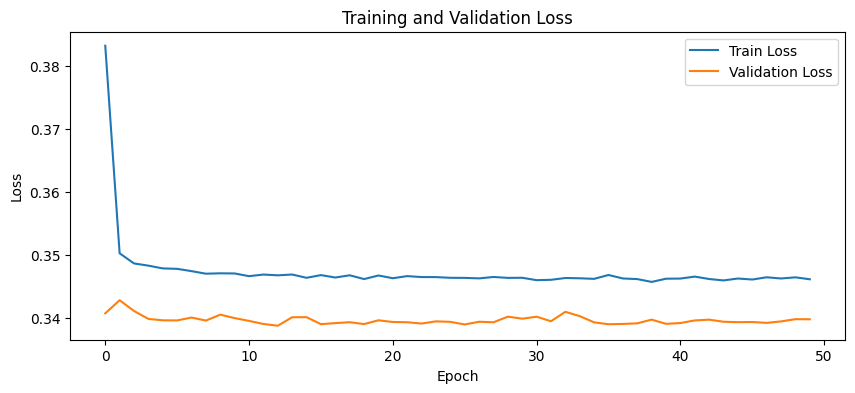

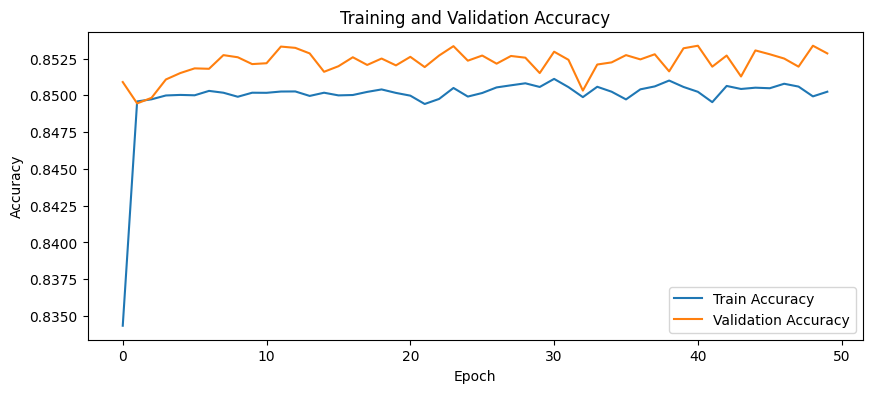

In [7]:
# Training summary charts/plots
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# If you tracked accuracy per epoch, plot accuracy curves (optional)
# Example: If you stored train_acc_list and val_acc_list per epoch, plot them as below:
plt.figure(figsize=(10, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()



# ✅ Load Aligned Tensors (if available)

This cell prefers `artifacts_aligned/*.pt` produced in Week 2. If not present, it falls back to your original tensors.


In [8]:
import os, torch
from torch.utils.data import TensorDataset, DataLoader


def load_tensor(path_fallback, path_aligned):
    if os.path.exists(path_aligned):
        return torch.load(path_aligned)
    return torch.load(path_fallback)


X_train_tensor = load_tensor("X_train_tensor.pt", "artifacts_aligned/X_train_tensor.pt")
y_train_tensor = load_tensor("y_train_tensor.pt", "artifacts_aligned/y_train_tensor.pt")
X_val_tensor = load_tensor("X_val_tensor.pt", "artifacts_aligned/X_val_tensor.pt")
y_val_tensor = load_tensor("y_val_tensor.pt", "artifacts_aligned/y_val_tensor.pt")
X_test_tensor = load_tensor("X_test_tensor.pt", "artifacts_aligned/X_test_tensor.pt")
y_test_tensor = load_tensor("y_test_tensor.pt", "artifacts_aligned/y_test_tensor.pt")

print(
    "Loaded tensors. Shapes:",
    X_train_tensor.shape,
    X_val_tensor.shape,
    X_test_tensor.shape,
)

batch_size = 64
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
val_loader = DataLoader(
    TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False
)

input_dim = X_train_tensor.shape[1]
print("input_dim =", input_dim)


Loaded tensors. Shapes: torch.Size([177576, 21]) torch.Size([38052, 21]) torch.Size([38052, 21])
input_dim = 21
